## Direction
Run all cells with imports and function definition followed by running main() at the bottom.

In [1]:
import numpy as np
import math
import time
import datetime
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Setting the figure size that will be used when plots are created.
plt.rcParams['figure.figsize'] = [12, 7]

In [2]:
# Importing and scaling the data
small = np.loadtxt("CS205_small_testdata__3.txt")
large = np.loadtxt('CS205_large_testdata__36.txt')
small_scaled = (small-np.amin(small, axis=0))/(np.amax(small, axis=0)-np.amin(small,axis=0))
large_scaled = (large-np.amin(large, axis=0))/(np.amax(large, axis=0)-np.amin(large,axis=0))

In [3]:
# Creating a function that will perform kNN
def knn(mat, crnt_set_, new_ftr, add = True):
    '''
    Compute accuracy of knn with k=1 for the given set of features
    '''
    acc = 0
    # Deep copy not to modify the object in the calling function
    crnt_set = crnt_set_[:]
    # Add or remove feature to the set depending whether forward or backward selection is used
    # For backward the first iteration does not remove anything which is controlled by providing
    # None for the new_ftr
    if new_ftr is not None:
        if add: 
            crnt_set.append(new_ftr)
        else:
            crnt_set.remove(new_ftr)
    
    # Recognizing that distance between row j and k is the same as between k and j allow to save 
    # computation and for each row compute distance from all the rows below it
    dist_mat = np.zeros((len(mat), len(mat)))
    np.fill_diagonal(dist_mat, np.inf)   # In order to ignore distance to itself being the minimum
  
    for i in range(0,len(mat)):
        obs = mat[i,crnt_set]    # The observation to classify
        # Compute distance from current row to all rows below it
        dist_mat[i+1:, i] = LA.norm(obs-mat[i+1:,crnt_set], axis=1)
    # Get the full distance matrix by adding to it its transpose due to symmetry
    dist = dist_mat + dist_mat.T
    closest_idcs = np.argmin(dist, axis = 1)  # Get index of lowest distance for each row
    # Compute accuracy by counting the number of labels that are the same as the lowest distance label
    acc = np.count_nonzero(mat[:,0] == mat[closest_idcs,0])
    return (acc/(len(mat)))

In [4]:
def fwd_ftr_search(mat):
    '''
    Performs forward selection to find best combination of features
    given the dataset.
    '''
    # List to keep track of all the current features
    crnt_ftr = []
    levels_best = []
    
    # Each level of the search tree
    for i in range(1,len(mat[1,:])):
        start = time.time()
        # List to keep track of the added feature
        add_ftr = -1
        # Keeps track of the best accuracy
        best_acc = -1
        print("On the", i, "th level of the search tree")
        
        # At each level, we want to see which features we can add
        for j in range(1,len(mat[1,:])):
            # At each level, I want to test the accuracy of adding a certain feature
            # but I don't want to consider a feature that's already included
            if j not in crnt_ftr:
                # Calculate the accuracy for the given set of features
                acc = knn(mat, crnt_ftr, j, add=True)  # Direct knn function to add feature to the list
                # Checking if we should add this feature based on how it compares
                # to the best accuracy so far.
                if acc > best_acc:
                    best_acc = acc
                    add_ftr = j # This is always updated when the accuracy is better.
                    
        # After we check all the features that we can add at this level
        # we want to make the current feature set is updated based on the best feature   
        crnt_ftr.append(add_ftr) 
        # The best combination of features and its accuracy at the current level
        levels_best.append((best_acc,crnt_ftr[:]))  # [:] is a copy of what is in the list now
        #print(add_ftr)
        print("*On level ", i, "added feature", add_ftr, "to current set*", "accuracy", best_acc, "time for level is", 
              round(time.time() - start,3))
    return(levels_best)

In [5]:
def backward_ftr_search(mat):
    '''
    Performs backward elimination to find best combination of features
    given the dataset.
    '''
    # List to keep track of all the current features
    crnt_ftr = [i for i in range(1,len(mat[1,:]))]
    levels_best = []
    # The accuracy with all possible features. Direct knn function to not remove anything from the feature list
    # in this case by setting new_ftr argument to None
    init_acc = knn(mat,crnt_ftr,None, add = False)
    levels_best.append((init_acc, crnt_ftr[:]))
    print(f"With all features accuracy {init_acc}")
     
    # Not removing the last feature so we have initial level with all features, plus 
    # P-1 levels, where P is number of features
    for i in range(1,len(mat[1,:])-1):
        start = time.time()
        # On the first level, we want the least accuracy to 
        # be the initial accuracy that we c
        # List to keep track of the removed feature
        rmv_ftr = -1
        # Keeps track of the best accuracy
        best_acc = -1
        print("On the", i, "th level of the search tree")
        
        # At each level, we want to see which feature we can remove
        for j in range(1,len(mat[1,:])):
            # At each level, I want to test the accuracy of adding a certain feature
            # but I don't want to consider a feature that's already included
            if j in crnt_ftr:
                # Calculate the accuracy for the given set of features
                acc = knn(mat, crnt_ftr, j, add = False)  # Direct knn function to remove feature from the list
                #acc = acc_class(j)
                # Checking if we should remove this feature based on how it compares
                # to the best accuracy so far.
                #print(best_acc,acc)
                if acc > best_acc:
                    best_acc = acc
                    rmv_ftr = j # This is always updated when the accuracy is worse.
                #print(add_ftr)
                
        # After we check all the features that we can remove at this level
        # we want to make the current feature set is updated based on the removal of 
        # the worst feature   
        crnt_ftr.remove(rmv_ftr) 
        # The best combination of features and its accuracy at the current level
        levels_best.append((best_acc,crnt_ftr[:]))  # [:] is a copy of what is in the list now
        print("*On level ", i, "removed feature",rmv_ftr, "to current set*", "accuracy", best_acc, "time for level is", 
              round(time.time() - start,3))
        #print(crnt_ftr)
        #print(crnt_ftr)
        #print(len(set(crnt_ftr)))
    return(levels_best)

In [6]:
##### Forward Selection with Small Dataset #######
print(datetime.datetime.now().time())
start = time.time()
# Testing the ftr_search function with the large dataset
acc_small_fwd = fwd_ftr_search(small)
end = time.time()
temp = end-start
print(temp)
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))
print(f"--- {(time.time() - start):.4f} seconds ---")
print(datetime.datetime.now().time())

16:12:13.622845
On the 1 th level of the search tree
*On level  1 added feature 4 to current set* accuracy 0.84 time for level is 0.107
On the 2 th level of the search tree
*On level  2 added feature 6 to current set* accuracy 0.9466666666666667 time for level is 0.083
On the 3 th level of the search tree
*On level  3 added feature 10 to current set* accuracy 0.9366666666666666 time for level is 0.101
On the 4 th level of the search tree
*On level  4 added feature 9 to current set* accuracy 0.92 time for level is 0.086
On the 5 th level of the search tree
*On level  5 added feature 7 to current set* accuracy 0.8966666666666666 time for level is 0.061
On the 6 th level of the search tree
*On level  6 added feature 8 to current set* accuracy 0.8833333333333333 time for level is 0.051
On the 7 th level of the search tree
*On level  7 added feature 1 to current set* accuracy 0.8333333333333334 time for level is 0.07
On the 8 th level of the search tree
*On level  8 added feature 2 to curre

In [60]:
# Best accuracy with choice of features for forward selection
# on small dataset
best_small_fwd = max(acc_small_fwd)

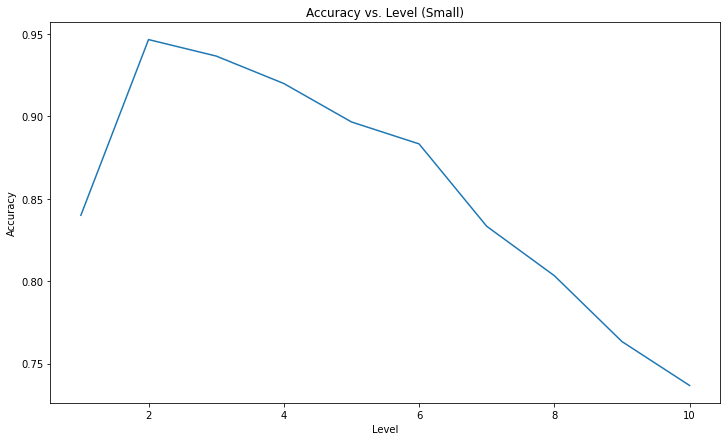

In [7]:
# Creating plot of accuracy vs. level for the small dataset 
# with forward selection
sml_lvls = [i+1 for i in range(0,len(acc_small_fwd))]
fwd_sml_acc = [acc_small_fwd[i][0] for i in range(0,len(acc_small_fwd))]
plt.plot(sml_lvls,fwd_sml_acc)
plt.xlabel('Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Level (Small)')
plt.show()

In [92]:
'''DO NOT RUN AGAIN IT WILL TAKE A LONG TIME'''
##### Forward Selection with Large Dataset #######
# ================
print(datetime.datetime.now().time())
start = time.time()
# Testing the ftr_search function with the large dataset
acc_large_fwd = fwd_ftr_search(large_scaled)
end = time.time()
temp = end-start
print(temp)
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))
print(f"--- {(time.time() - start)/60:.4f} minutes ---")
print(datetime.datetime.now().time())

09:58:49.553491
On the 1 th level of the search tree
*On level  1 added feature 93 to current set* time for level is 8.692
On the 2 th level of the search tree
*On level  2 added feature 129 to current set* time for level is 10.326
On the 3 th level of the search tree
*On level  3 added feature 23 to current set* time for level is 10.688
On the 4 th level of the search tree
*On level  4 added feature 36 to current set* time for level is 10.119
On the 5 th level of the search tree
*On level  5 added feature 43 to current set* time for level is 10.622
On the 6 th level of the search tree
*On level  6 added feature 186 to current set* time for level is 10.999
On the 7 th level of the search tree
*On level  7 added feature 77 to current set* time for level is 11.294
On the 8 th level of the search tree
*On level  8 added feature 165 to current set* time for level is 11.545
On the 9 th level of the search tree
*On level  9 added feature 137 to current set* time for level is 12.446
On the 10

*On level  75 added feature 14 to current set* time for level is 39.055
On the 76 th level of the search tree
*On level  76 added feature 113 to current set* time for level is 40.043
On the 77 th level of the search tree
*On level  77 added feature 105 to current set* time for level is 44.941
On the 78 th level of the search tree
*On level  78 added feature 95 to current set* time for level is 45.19
On the 79 th level of the search tree
*On level  79 added feature 244 to current set* time for level is 50.525
On the 80 th level of the search tree
*On level  80 added feature 5 to current set* time for level is 52.451
On the 81 th level of the search tree
*On level  81 added feature 200 to current set* time for level is 53.156
On the 82 th level of the search tree
*On level  82 added feature 180 to current set* time for level is 55.268
On the 83 th level of the search tree
*On level  83 added feature 68 to current set* time for level is 55.854
On the 84 th level of the search tree
*On lev

*On level  149 added feature 216 to current set* time for level is 76.136
On the 150 th level of the search tree
*On level  150 added feature 127 to current set* time for level is 76.056
On the 151 th level of the search tree
*On level  151 added feature 233 to current set* time for level is 76.395
On the 152 th level of the search tree
*On level  152 added feature 231 to current set* time for level is 74.448
On the 153 th level of the search tree
*On level  153 added feature 178 to current set* time for level is 73.754
On the 154 th level of the search tree
*On level  154 added feature 38 to current set* time for level is 77.102
On the 155 th level of the search tree
*On level  155 added feature 25 to current set* time for level is 73.942
On the 156 th level of the search tree
*On level  156 added feature 18 to current set* time for level is 72.835
On the 157 th level of the search tree
*On level  157 added feature 159 to current set* time for level is 73.162
On the 158 th level of th

*On level  222 added feature 158 to current set* time for level is 33.508
On the 223 th level of the search tree
*On level  223 added feature 67 to current set* time for level is 34.219
On the 224 th level of the search tree
*On level  224 added feature 73 to current set* time for level is 32.386
On the 225 th level of the search tree
*On level  225 added feature 242 to current set* time for level is 30.373
On the 226 th level of the search tree
*On level  226 added feature 108 to current set* time for level is 30.745
On the 227 th level of the search tree
*On level  227 added feature 91 to current set* time for level is 30.924
On the 228 th level of the search tree
*On level  228 added feature 96 to current set* time for level is 27.583
On the 229 th level of the search tree
*On level  229 added feature 181 to current set* time for level is 26.857
On the 230 th level of the search tree
*On level  230 added feature 131 to current set* time for level is 25.802
On the 231 th level of the

In [81]:
# Best accuracy with choice of features for forward selection 
# on large dataset
best_large_fwd = max(acc_large_fwd)

(0.9811111111111112, [93, 129])

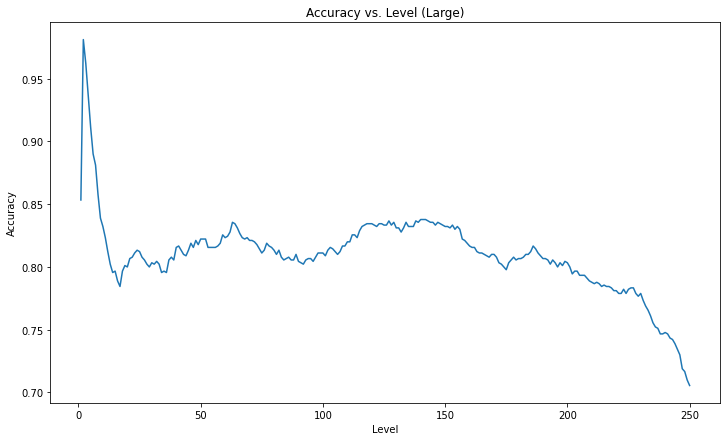

In [14]:
# Creating plot of accuracy vs. level for the large dataset 
# with forward selection
large_lvls = [i+1 for i in range(0,len(acc_large_fwd))]
fwd_large_acc = [acc_large_fwd[i][0] for i in range(0,len(acc_large_fwd))]
plt.plot(large_lvls,fwd_large_acc)
plt.xlabel('Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Level (Large)')
plt.show()

In [15]:
##### Backward Elimination with Small Dataset #######
print(datetime.datetime.now().time())
start = time.time()
# Testing the ftr_search function with the large dataset
acc_small_bwd = backward_ftr_search(small_scaled)
end = time.time()
temp = end-start
print(temp)
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))
print(f"--- {(time.time() - start)/60:.4f} minutes ---")
print(datetime.datetime.now().time())

16:15:03.431796
With all features accuracy 0.7266666666666667
On the 1 th level of the search tree
*On level  1 removed feature 8 to current set* accuracy 0.7866666666666666 time for level is 0.128
On the 2 th level of the search tree
*On level  2 removed feature 5 to current set* accuracy 0.8133333333333334 time for level is 0.098
On the 3 th level of the search tree
*On level  3 removed feature 1 to current set* accuracy 0.8133333333333334 time for level is 0.108
On the 4 th level of the search tree
*On level  4 removed feature 2 to current set* accuracy 0.8533333333333334 time for level is 0.07
On the 5 th level of the search tree
*On level  5 removed feature 3 to current set* accuracy 0.8866666666666667 time for level is 0.072
On the 6 th level of the search tree
*On level  6 removed feature 7 to current set* accuracy 0.9166666666666666 time for level is 0.054
On the 7 th level of the search tree
*On level  7 removed feature 9 to current set* accuracy 0.9366666666666666 time for le

In [58]:
# Best accuracy with choice of features for backward elimination 
# on small dataset
best_small_bw = max(acc_small_bwd)

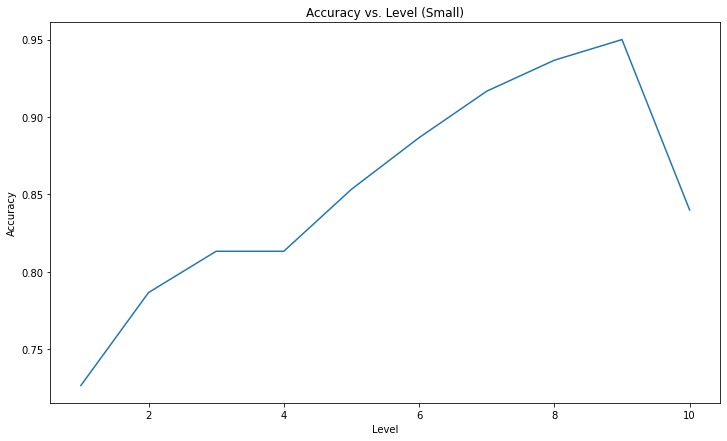

In [16]:
# Creating plot of accuracy vs. level for the small dataset 
# with backward elimination
bwd_sml_acc = [acc_small_bwd[i][0] for i in range(0,len(acc_small_bwd))]
plt.plot(sml_lvls,bwd_sml_acc)
plt.xlabel('Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Level (Small)')
plt.show()

In [99]:
'''DO NOT RUN AGAIN IT WILL TAKE A LONG TIME'''
##### Backward Elimination with Large Dataset #######
# ================
print(datetime.datetime.now().time())
start = time.time()
# Testing the ftr_search function with the large dataset
acc_large_bwd = backward_ftr_search(large_scaled)
end = time.time()
temp = end-start
print(temp)
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('%d:%d:%d' %(hours,minutes,seconds))
print(f"--- {(time.time() - start)/60:.4f} minutes ---")
print(datetime.datetime.now().time())

21:04:47.403776
With all features accuracy 0.7055555555555556
On the 1 th level of the search tree
*On level  1 removed feature 149 to current set* accuracy 0.7155555555555555 time for level is 262.463
On the 2 th level of the search tree
*On level  2 removed feature 235 to current set* accuracy 0.7233333333333334 time for level is 256.537
On the 3 th level of the search tree
*On level  3 removed feature 191 to current set* accuracy 0.7266666666666667 time for level is 253.905
On the 4 th level of the search tree
*On level  4 removed feature 147 to current set* accuracy 0.7333333333333333 time for level is 251.882
On the 5 th level of the search tree
*On level  5 removed feature 246 to current set* accuracy 0.7355555555555555 time for level is 250.576
On the 6 th level of the search tree
*On level  6 removed feature 126 to current set* accuracy 0.7366666666666667 time for level is 245.102
On the 7 th level of the search tree
*On level  7 removed feature 125 to current set* accuracy 0.7

*On level  60 removed feature 68 to current set* accuracy 0.8233333333333334 time for level is 123.705
On the 61 th level of the search tree
*On level  61 removed feature 3 to current set* accuracy 0.8255555555555556 time for level is 121.464
On the 62 th level of the search tree
*On level  62 removed feature 103 to current set* accuracy 0.8288888888888889 time for level is 120.764
On the 63 th level of the search tree
*On level  63 removed feature 104 to current set* accuracy 0.83 time for level is 117.704
On the 64 th level of the search tree
*On level  64 removed feature 142 to current set* accuracy 0.8311111111111111 time for level is 115.777
On the 65 th level of the search tree
*On level  65 removed feature 195 to current set* accuracy 0.8322222222222222 time for level is 114.685
On the 66 th level of the search tree
*On level  66 removed feature 58 to current set* accuracy 0.8322222222222222 time for level is 110.296
On the 67 th level of the search tree
*On level  67 removed fe

*On level  119 removed feature 30 to current set* accuracy 0.8311111111111111 time for level is 27.821
On the 120 th level of the search tree
*On level  120 removed feature 155 to current set* accuracy 0.8322222222222222 time for level is 26.638
On the 121 th level of the search tree
*On level  121 removed feature 80 to current set* accuracy 0.8311111111111111 time for level is 26.357
On the 122 th level of the search tree
*On level  122 removed feature 18 to current set* accuracy 0.8333333333333334 time for level is 25.98
On the 123 th level of the search tree
*On level  123 removed feature 243 to current set* accuracy 0.8322222222222222 time for level is 25.301
On the 124 th level of the search tree
*On level  124 removed feature 98 to current set* accuracy 0.8333333333333334 time for level is 26.151
On the 125 th level of the search tree
*On level  125 removed feature 245 to current set* accuracy 0.8355555555555556 time for level is 25.435
On the 126 th level of the search tree
*On 

*On level  178 removed feature 57 to current set* accuracy 0.8344444444444444 time for level is 10.171
On the 179 th level of the search tree
*On level  179 removed feature 132 to current set* accuracy 0.8366666666666667 time for level is 9.238
On the 180 th level of the search tree
*On level  180 removed feature 38 to current set* accuracy 0.8355555555555556 time for level is 9.777
On the 181 th level of the search tree
*On level  181 removed feature 24 to current set* accuracy 0.8322222222222222 time for level is 8.857
On the 182 th level of the search tree
*On level  182 removed feature 85 to current set* accuracy 0.8311111111111111 time for level is 8.661
On the 183 th level of the search tree
*On level  183 removed feature 92 to current set* accuracy 0.8311111111111111 time for level is 8.424
On the 184 th level of the search tree
*On level  184 removed feature 93 to current set* accuracy 0.83 time for level is 8.192
On the 185 th level of the search tree
*On level  185 removed fe

*On level  237 removed feature 154 to current set* accuracy 0.7811111111111111 time for level is 0.778
On the 238 th level of the search tree
*On level  238 removed feature 204 to current set* accuracy 0.7811111111111111 time for level is 0.712
On the 239 th level of the search tree
*On level  239 removed feature 7 to current set* accuracy 0.7755555555555556 time for level is 0.653
On the 240 th level of the search tree
*On level  240 removed feature 114 to current set* accuracy 0.7722222222222223 time for level is 0.584
On the 241 th level of the search tree
*On level  241 removed feature 122 to current set* accuracy 0.7566666666666667 time for level is 0.488
On the 242 th level of the search tree
*On level  242 removed feature 192 to current set* accuracy 0.7511111111111111 time for level is 0.427
On the 243 th level of the search tree
*On level  243 removed feature 188 to current set* accuracy 0.7466666666666667 time for level is 0.35
On the 244 th level of the search tree
*On level

In [62]:
# Best accuracy with choice of features for backward elimination 
# on large dataset
best_small_bw = max(acc_large_bwd)

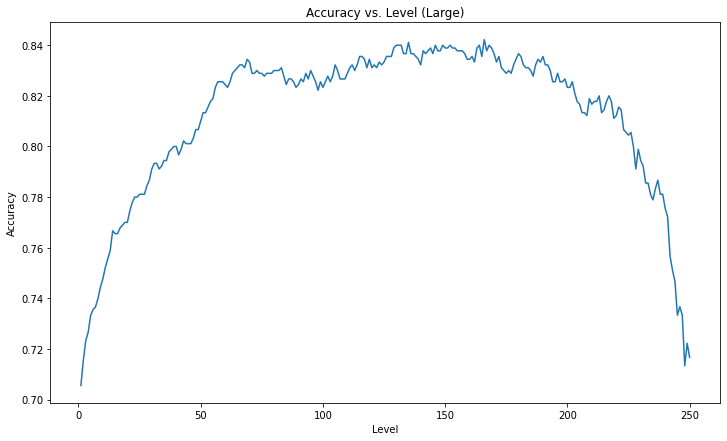

In [19]:
# Creating plot of accuracy vs. level for the large dataset 
# with backward elimination
bwd_large_acc = [acc_large_bwd[i][0] for i in range(0,len(acc_large_bwd))]
plt.plot(large_lvls,bwd_large_acc)
plt.xlabel('Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Level (Large)')
plt.show()

In [79]:
# Creating a user interface so that the user can choose 
# which search algorithm to use and which dataset to use.
def main():
    # Asking the user for a data file 
    file_success = False
    while not file_success:
        # Testing to make sure the file can be loaded
        try:
            file = input("This is a Feature Selection Algorithm for the kNN classification method.\
                  \n Please type in the name of the file you want to test:")
            mat = np.loadtxt(file)
            file_success = True
        except:
            print("\n***ERROR***\nPlease enter a valid file")
    
    # Placeholder for search algo to start while loop
    search = 0
    # Making sure user enter's valid search algorithm
    while search != 1 and search != 2:
        # Asking the user which algorithm they want to use
        search = int(input("\nEnter the search algorithm you want to use: (1) Forward Selection (2) Backward Elimination:"))
    
    print()
    # Run kNN with the corresponding search algorithm
    if search == 1: # forward 
        acc = fwd_ftr_search(mat)
    else: # backward
        acc = backward_ftr_search(mat)
        
    # Saving best accuracy to print out to the user
    best_acc = max(acc)[0]
    best_ftr = max(acc)[1]
    print("\n\nThe search is completed. The best feature set to use is", best_ftr,"with an accuracy of", round(100*best_acc,2),"%")
    

In [80]:
main()

This is a Feature Selection Algorithm for the kNN classification method.                  
 Please type in the name of the file you want to test:CS205_small_testdata__3.txt

Enter the search algorithm you want to use: (1) Forward Selection (2) Backward Elimination:1

On the 1 th level of the search tree
*On level  1 added feature 4 to current set* accuracy 0.84 time for level is 0.103
On the 2 th level of the search tree
*On level  2 added feature 6 to current set* accuracy 0.9466666666666667 time for level is 0.094
On the 3 th level of the search tree
*On level  3 added feature 10 to current set* accuracy 0.9366666666666666 time for level is 0.102
On the 4 th level of the search tree
*On level  4 added feature 9 to current set* accuracy 0.92 time for level is 0.072
On the 5 th level of the search tree
*On level  5 added feature 7 to current set* accuracy 0.8966666666666666 time for level is 0.061
On the 6 th level of the search tree
*On level  6 added feature 8 to current set* accurac